<a href="https://colab.research.google.com/github/vmpreciado/NETS3120/blob/main/FBClustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this Jupyter Notebook, we conduct a clustering analysis of Facebook social network data. The objective is to identify distinct communities within the network, leveraging the graph structure of friendships. This analysis provides insights into how social clusters form based on mutual connections and shared interests. We'll use the NetworkX library for graph manipulation, Matplotlib and Seaborn for visualization, and Scikit-learn for implementing clustering algorithms.

First, we load the Facebook dataset into our environment. This dataset consists of nodes representing Facebook users and edges representing friendships between them. We utilize the NetworkX library to create a graph object from the dataset, allowing for easy manipulation and analysis of the network's properties.


In [8]:
# Import necessary libraries
from google.colab import drive
import networkx as nx

# Mount Google Drive
drive.mount('/content/drive')

# Path to your file on Google Drive: 1) Download facebook_combined.txt.gz; 2) Decompressed as a .txt; 3) Rename and locate wherever you like...
file_path = '/content/drive/My Drive/ColabNotebooks/FacebookSmall.txt'

# Create a new graph and name it FB
FB = nx.Graph()# Create a graph from the edgelist file
FB = nx.read_edgelist(file_path, create_using=nx.Graph(), nodetype=int)

# Perform initial checks
print(f"Number of nodes: {FB.number_of_nodes()}")
print(f"Number of edges: {FB.number_of_edges()}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Number of nodes: 4039
Number of edges: 88234


Let's compute a sequence of clustering coefficients for each node. Let's plot a histogram of the values and the total average in the graph. (By convention, isolated nodes have a clustering coefficient equal to zero.)

Average Clustering Coefficient: 0.6055467186200876


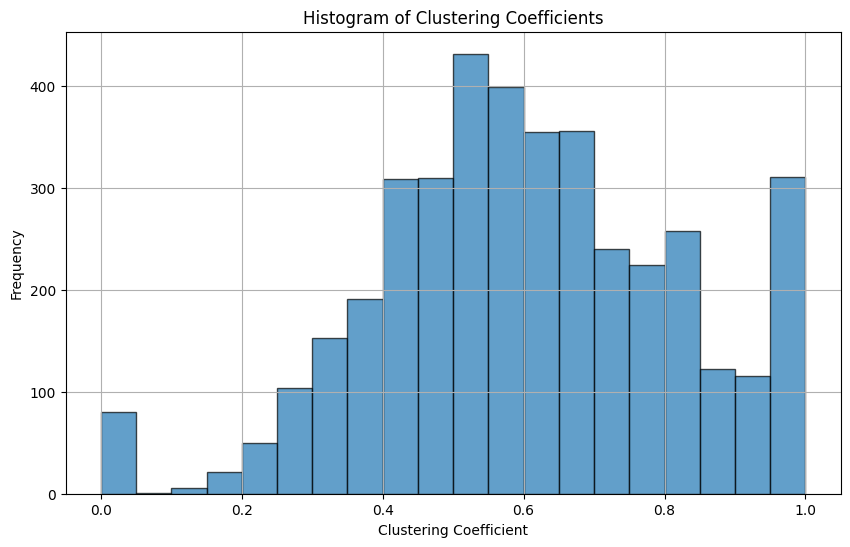

In [9]:
import matplotlib.pyplot as plt

# Computing clustering coefficients for each node
clustering_coefficients = nx.clustering(FB)
clustering_coefficients_list = list(clustering_coefficients.values()) # transform into a list for convenience

# Computing the average clustering coefficient
average_clustering_coefficient = nx.average_clustering(FB)
print(f"Average Clustering Coefficient: {average_clustering_coefficient}")

# Create a histogram of the clustering coefficients
plt.figure(figsize=(10, 6))
plt.hist(clustering_coefficients_list, bins=20, edgecolor='black', alpha=0.7)

plt.title('Histogram of Clustering Coefficients')
plt.xlabel('Clustering Coefficient')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

This is a very high average clustering coefficient, indicating that the subgraph of facebook we are analyzing is part of a community. The average clustering coefficient equal to 0.60 can be interpreted as follows: The probability of two random friends of a random node being connected is approx 60%

Let's shift gears and evaluate the use of Jacard and AA indexes as predictors of connected nodes. The following code computes the Jaccard similarity and Adamic-Adar index for randomly sampled pairs of nodes in a given network FB, distinguishing between connected and disconnected pairs. It iteratively selects random node pairs, retrieves their neighbors, and calculates these similarity measures based on shared and total neighbors. The results are stored separately for 10,000 connected and 10,000 disconnected pairs, providing a dataset that can be used for link prediction analysis by comparing structural similarities between existing and non-existing edges.

In [10]:
import random
import numpy as np

# Computing the degree of each node
degrees = dict(FB.degree())
nodes = list(FB.nodes())

# Initialize lists to store the indices
connected_jaccard, disconnected_jaccard = [], []
connected_adamic_adar, disconnected_adamic_adar = [], []

while len(connected_jaccard) < 10000 or len(disconnected_jaccard) < 10000:
    i, j = random.sample(nodes, 2)

    # Compute the common neighbors and total unique neighbors
    neighbors_i = set(FB.neighbors(i))
    neighbors_j = set(FB.neighbors(j))
    common_neighbors = neighbors_i.intersection(neighbors_j)
    all_neighbors = neighbors_i.union(neighbors_j)

    # Compute Jaccard index
    jaccard_index = len(common_neighbors) / len(all_neighbors) if all_neighbors else 0

    # Compute Adamic-Adar index
    adamic_adar_index = sum(1 / np.log(degrees[k]) for k in common_neighbors) if common_neighbors else 0

    if FB.has_edge(i, j):
        if len(connected_jaccard) < 10000:
            connected_jaccard.append(jaccard_index)
            connected_adamic_adar.append(adamic_adar_index)
    else:
        if len(disconnected_jaccard) < 10000:
            disconnected_jaccard.append(jaccard_index)
            disconnected_adamic_adar.append(adamic_adar_index)

The following code generates histograms to compare the distribution of Jaccard Index and Adamic-Adar Index for connected and disconnected node pairs in a network. The histograms are color-coded (blue for connected, red for disconnected). This helps analyze structural differences between existing and non-existing edges, useful for link prediction in networks.

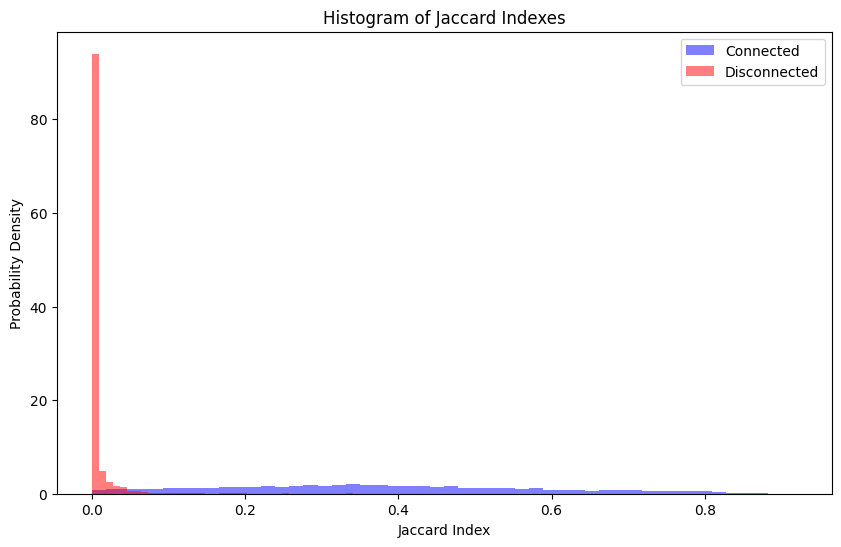

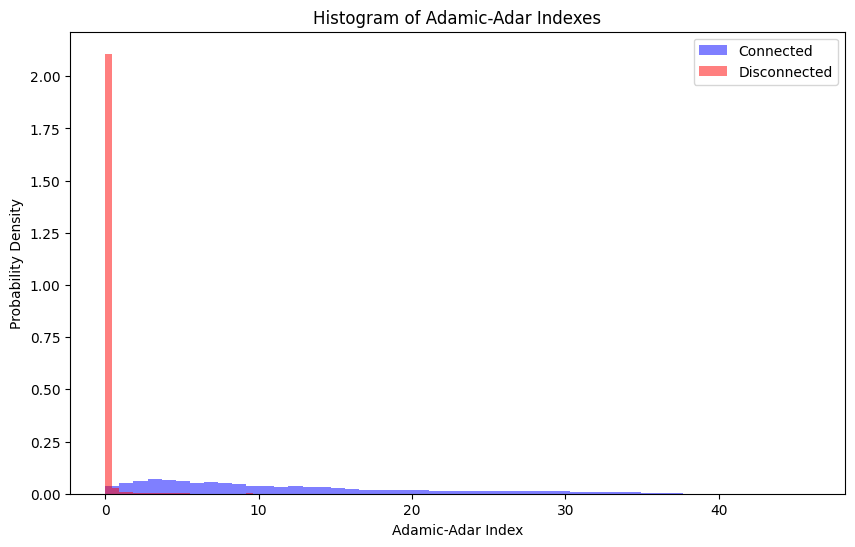

In [11]:
import matplotlib.pyplot as plt

# Determine the range of the data
data_range = [min(connected_jaccard + disconnected_jaccard), max(connected_jaccard + disconnected_jaccard)]

# Number of bins
n_bins_blue = 50  # Adjust based on data

# Plotting histograms with normalization
plt.figure(figsize=(10, 6))
plt.hist(connected_jaccard, bins=n_bins_blue, range=data_range, color='blue', alpha=0.5, label='Connected', density=True)
plt.hist(disconnected_jaccard, bins=n_bins_blue * 2, range=data_range, color='red', alpha=0.5, label='Disconnected', density=True)
plt.title('Histogram of Jaccard Indexes')
plt.xlabel('Jaccard Index')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

# Determine the range of the data
data_range = [min(connected_adamic_adar + disconnected_adamic_adar), max(connected_adamic_adar + disconnected_adamic_adar)]

# Number of bins
n_bins_blue = 50  # Adjust as needed

# Plotting histograms with normalization
plt.figure(figsize=(10, 6))
plt.hist(connected_adamic_adar, bins=n_bins_blue, range=data_range, color='blue', alpha=0.5, label='Connected', density=True)
plt.hist(disconnected_adamic_adar, bins=n_bins_blue * 2, range=data_range, color='red', alpha=0.5, label='Disconnected', density=True)
plt.title('Histogram of Adamic-Adar Indexes')
plt.xlabel('Adamic-Adar Index')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

Conclusions from the Plots

Jaccard Index Histogram: The Jaccard index for connected pairs (blue) is distributed over a broad range (0 to ~0.8), with many values concentrated in the mid-range (0.2 - 0.6).
The Jaccard index for disconnected pairs (red) is heavily concentrated at zero, meaning most disconnected node pairs share no common neighbors. This suggests that the Jaccard index does differentiate between connected and disconnected pairs, but there is considerable overlap, which reduces its predictive power.

Adamic-Adar Index Histogram: The Adamic-Adar index for connected pairs (blue) is broadly distributed, extending up to 40+, with a clear distinction from disconnected pairs. The Adamic-Adar index for disconnected pairs (red) is mostly concentrated near zero, similar to the Jaccard index. The key difference is that connected pairs tend to have much higher Adamic-Adar scores, making it easier to distinguish them from disconnected pairs.

Which Index is More Discriminative for Link Prediction? The Adamic-Adar index is more discriminative than the Jaccard index for predicting links. The Adamic-Adar index provides a clearer separation, where connected pairs have consistently higher scores compared to disconnected ones. Thus, for link prediction, the Adamic-Adar index would likely be the better metric as it better differentiates between existing and non-existing links.

GO BACK TO SLIDES TO SEE HOW TO USE THESE HISTOGRAMS IN A CLASSIFICATION SETTING...

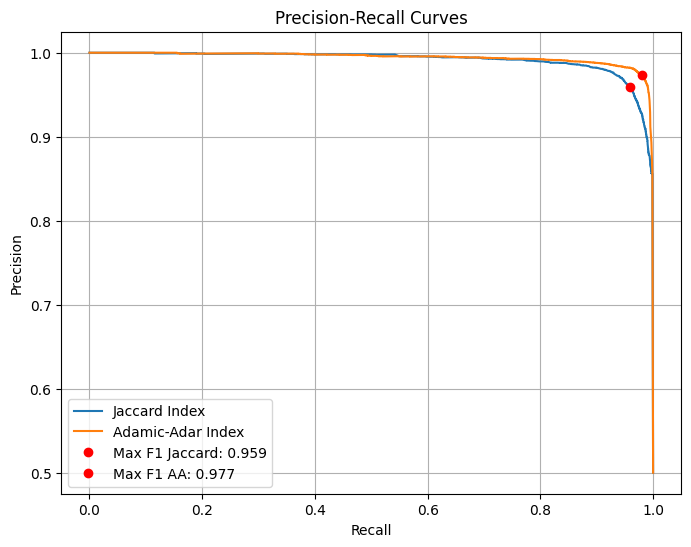

Optimal thresholds:
Jaccard: 0.0439
Adamic-Adar: 0.6287

Performance at optimal thresholds:
Jaccard:
Precision: 0.9593
Recall: 0.9590
F1: 0.9591

Adamic-Adar:
Precision: 0.9738
Recall: 0.9801
F1: 0.9769


In [12]:
import numpy as np
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Calculate priors based on network density
n_nodes = FB.number_of_nodes()
total_possible_pairs = n_nodes * (n_nodes-1) / 2
prior_connected = FB.number_of_edges() / total_possible_pairs
prior_disconnected = 1 - prior_connected

# Fit distributions to likelihood ratios
def fit_likelihood_ratio(connected_vals, disconnected_vals, bins=50):
   hist_conn, bins = np.histogram(connected_vals, bins=bins, density=True)
   hist_disconn, _ = np.histogram(disconnected_vals, bins=bins, density=True)
   # Add small constant to avoid division by zero
   likelihood_ratio = (hist_conn + 1e-10) / (hist_disconn + 1e-10)
   bin_centers = (bins[:-1] + bins[1:]) / 2
   return bin_centers, likelihood_ratio

# Calculate likelihood ratios for both metrics
jaccard_bins, jaccard_lr = fit_likelihood_ratio(connected_jaccard, disconnected_jaccard)
aa_bins, aa_lr = fit_likelihood_ratio(connected_adamic_adar, disconnected_adamic_adar)

# Make predictions and calculate metrics
def evaluate_predictions(values, threshold, true_connected):
   predictions = values >= threshold
   true_pos = np.sum(predictions & true_connected)
   false_pos = np.sum(predictions & ~true_connected)
   false_neg = np.sum(~predictions & true_connected)

   precision = true_pos / (true_pos + false_pos)
   recall = true_pos / (true_pos + false_neg)
   f1 = 2 * (precision * recall) / (precision + recall)
   return precision, recall, f1

# Combine all scores and true labels
all_jaccard = np.concatenate([connected_jaccard, disconnected_jaccard])
all_aa = np.concatenate([connected_adamic_adar, disconnected_adamic_adar])
true_labels = np.concatenate([np.ones(len(connected_jaccard)),
                           np.zeros(len(disconnected_jaccard))])

# Calculate precision-recall curves
prec_j, rec_j, thresh_j = precision_recall_curve(true_labels, all_jaccard)
prec_aa, rec_aa, thresh_aa = precision_recall_curve(true_labels, all_aa)

# Calculate F1 scores
f1_j = 2 * (prec_j[:-1] * rec_j[:-1]) / (prec_j[:-1] + rec_j[:-1])
f1_aa = 2 * (prec_aa[:-1] * rec_aa[:-1]) / (prec_aa[:-1] + rec_aa[:-1])

# Find optimal points
max_f1_j_idx = np.argmax(f1_j)
max_f1_aa_idx = np.argmax(f1_aa)

# Plot precision-recall curves
plt.figure(figsize=(8, 6))
plt.plot(rec_j, prec_j, label='Jaccard Index')
plt.plot(rec_aa, prec_aa, label='Adamic-Adar Index')

# Plot optimal points
plt.plot(rec_j[max_f1_j_idx], prec_j[max_f1_j_idx], 'ro',
        label=f'Max F1 Jaccard: {f1_j[max_f1_j_idx]:.3f}')
plt.plot(rec_aa[max_f1_aa_idx], prec_aa[max_f1_aa_idx], 'ro',
        label=f'Max F1 AA: {f1_aa[max_f1_aa_idx]:.3f}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.grid(True)
plt.show()

# Get optimal thresholds
optimal_thresh_j = thresh_j[max_f1_j_idx]
optimal_thresh_aa = thresh_aa[max_f1_aa_idx]

print("Optimal thresholds:")
print(f"Jaccard: {optimal_thresh_j:.4f}")
print(f"Adamic-Adar: {optimal_thresh_aa:.4f}")

# Print performance metrics at optimal thresholds
print("\nPerformance at optimal thresholds:")
print("Jaccard:")
prec_j_opt, rec_j_opt, f1_j_opt = evaluate_predictions(all_jaccard, optimal_thresh_j, true_labels.astype(bool))
print(f"Precision: {prec_j_opt:.4f}")
print(f"Recall: {rec_j_opt:.4f}")
print(f"F1: {f1_j_opt:.4f}")

print("\nAdamic-Adar:")
prec_aa_opt, rec_aa_opt, f1_aa_opt = evaluate_predictions(all_aa, optimal_thresh_aa, true_labels.astype(bool))
print(f"Precision: {prec_aa_opt:.4f}")
print(f"Recall: {rec_aa_opt:.4f}")
print(f"F1: {f1_aa_opt:.4f}")